# Time Series Forcasting with a Linear Regression Model

In [488]:
import pandas as pd
with open("../data/current_measurements.json") as file:
    df = pd.read_json(file)

In [489]:
df = df.iloc[::-1] # reverse the order, the data was ordered by DATE DESC, but we want the more recent data to be used in the test set
df['measuredAt'] = pd.to_datetime(df['measuredAt'])
df.index = df['measuredAt']
del(df['measuredAt'])

In [490]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 12

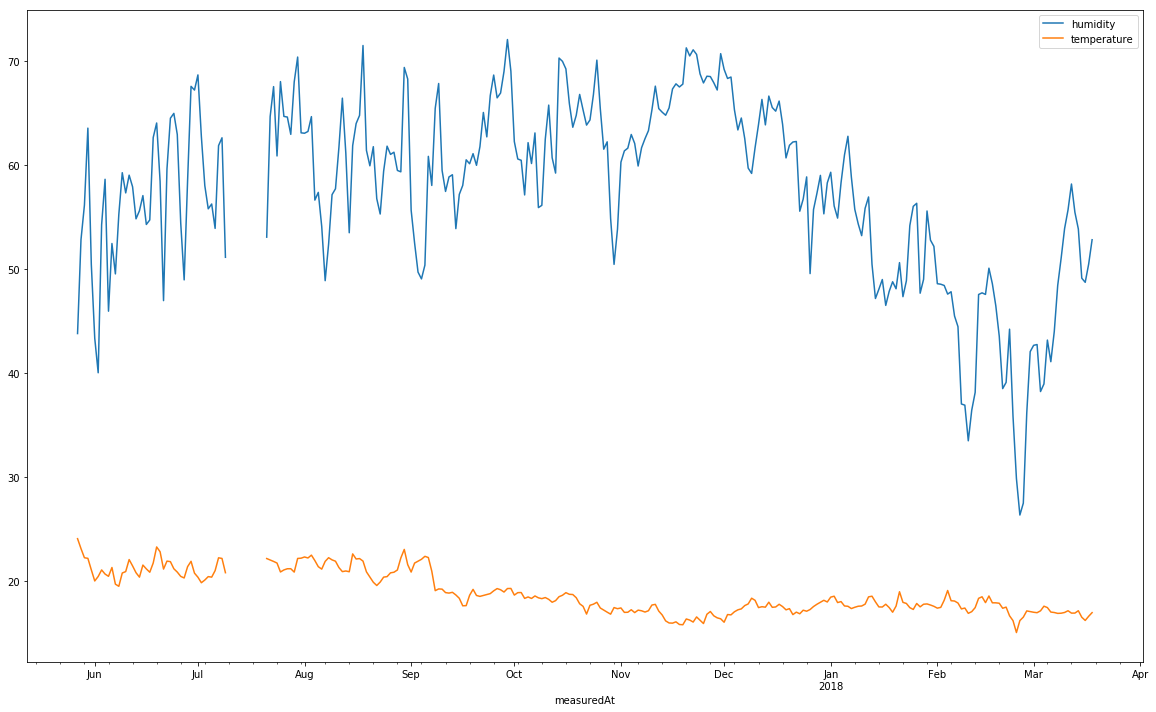

In [491]:
df.resample('D').mean().plot()

In [492]:
df.index

DatetimeIndex(['2017-05-27 16:11:57.235106', '2017-05-27 17:19:42.369249',
               '2017-05-27 17:23:30.756653', '2017-05-27 18:00:17.092384',
               '2017-05-27 18:35:47.109730', '2017-05-27 18:40:53.500771',
               '2017-05-27 19:00:13.771968', '2017-05-27 20:00:10.138441',
               '2017-05-27 21:00:09.525139', '2017-05-27 22:00:40.576659',
               ...
               '2018-03-17 23:00:12.215044', '2018-03-18 00:00:07.169311',
               '2018-03-18 01:00:07.277118', '2018-03-18 02:00:09.256703',
               '2018-03-18 03:00:09.652550', '2018-03-18 04:00:11.143315',
               '2018-03-18 05:00:07.071877', '2018-03-18 06:00:10.555854',
               '2018-03-18 07:00:18.167119', '2018-03-18 08:00:07.383029'],
              dtype='datetime64[ns]', name='measuredAt', length=6746, freq=None)

## building a training and test set

In [493]:
test_size = 0.2
lookback = 24

In [494]:
import numpy as np
dataset = df.humidity.values

In [495]:
X, y = [], []
for i in range(lookback, len(dataset) - lookback):
    X.append(dataset[i-lookback:i])
    y.append(dataset[i:i+lookback])


In [496]:
# split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

## Training the model

In [497]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [498]:
predicted_train = lin_reg.predict(X_train)
predicted_test = lin_reg.predict(X_test)

## Evaluating the results

Visualization of the 1 hour ahead prediction

In [504]:
def prepare_plot_data(df, lookback, predicted_train, predicted_test, max_ahead = False):
    if max_ahead:
        offset = lookback * 2
        index = -1
    else:
        offset = lookback
        index = 0
        
    predicted_train_plot = []
    for i in range(0, predicted_train.shape[0]):
        predicted_train_plot = np.append(predicted_train_plot, predicted_train[i, index])
    
    predicted_test_plot = []
    for i in range(0, predicted_test.shape[0]):
        predicted_test_plot = np.append(predicted_test_plot, predicted_test[i, index])
    
    measured = df[offset:]
    plot_X_train = df.index[offset:len(predicted_train_plot) + offset]
    plot_X_test = df.index[offset + len(predicted_train_plot):offset + len(predicted_train_plot) + len(predicted_test_plot)]
    return measured, plot_X_train, predicted_train_plot, plot_X_test, predicted_test_plot


def visualize_predictions(df, lookback, predicted_train, predicted_test, show_measured = True, max_ahead = False, train_color="salmon", test_color="red", label = "predicted"):
    measured, plot_X_train, plot_y_train, plot_X_test, plot_y_test = prepare_plot_data(df, lookback, predicted_train, predicted_test, max_ahead)
    plt.subplot()
    if show_measured:
        plt.plot(measured.index, measured.humidity, color="gray")
    plt.plot(plot_X_train, plot_y_train, color = train_color, label = label + " train")
    plt.plot(plot_X_test, plot_y_test, color = test_color, label = label + " test")
    plt.legend()

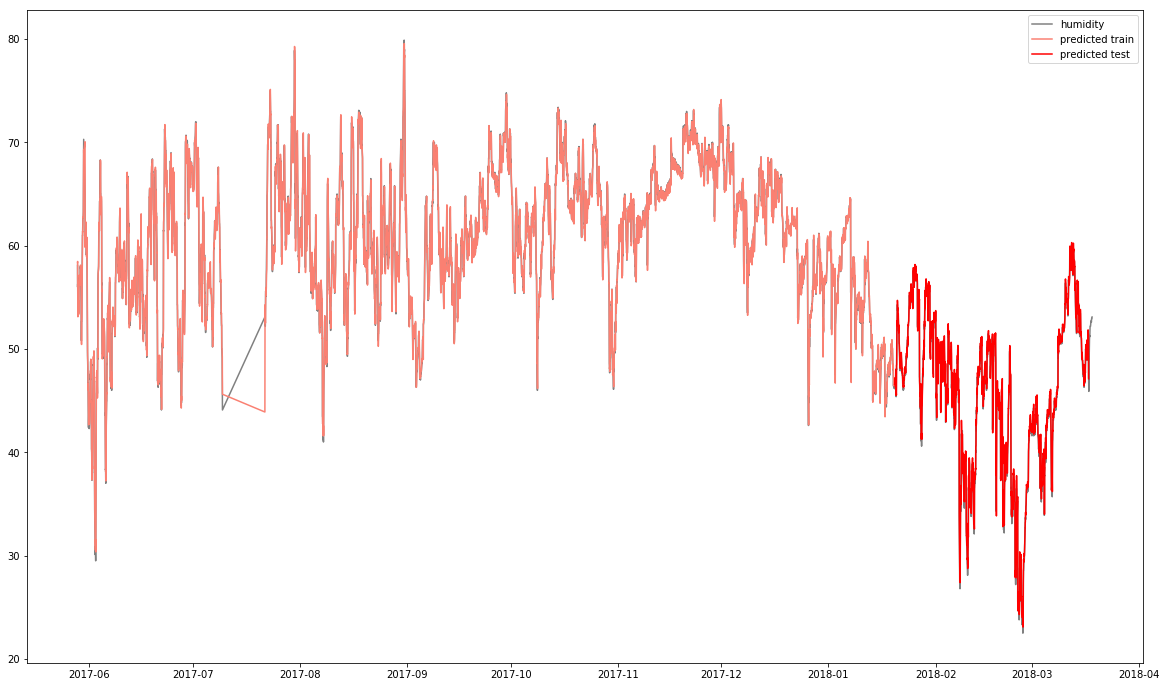

In [505]:
visualize_predictions(df, lookback, predicted_train, predicted_test)

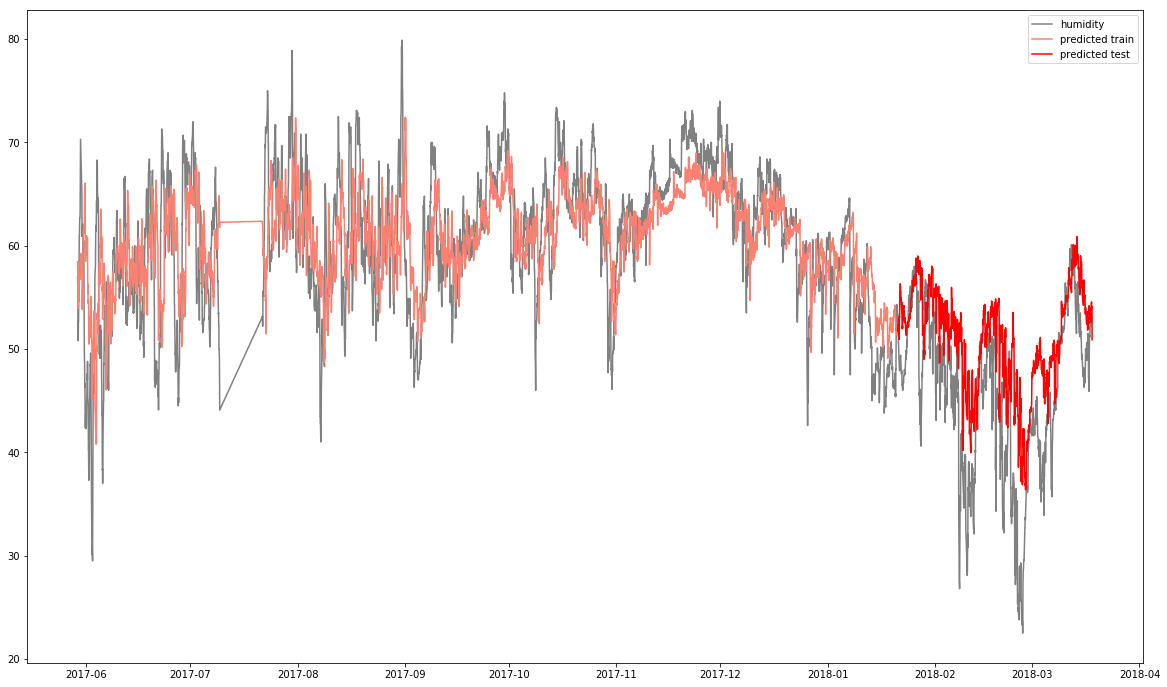

In [506]:
visualize_predictions(df, lookback, predicted_train, predicted_test, max_ahead = True)

Visualizing the differences

/Users/oem/.pyenv/versions/3.6.3/envs/habitat/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


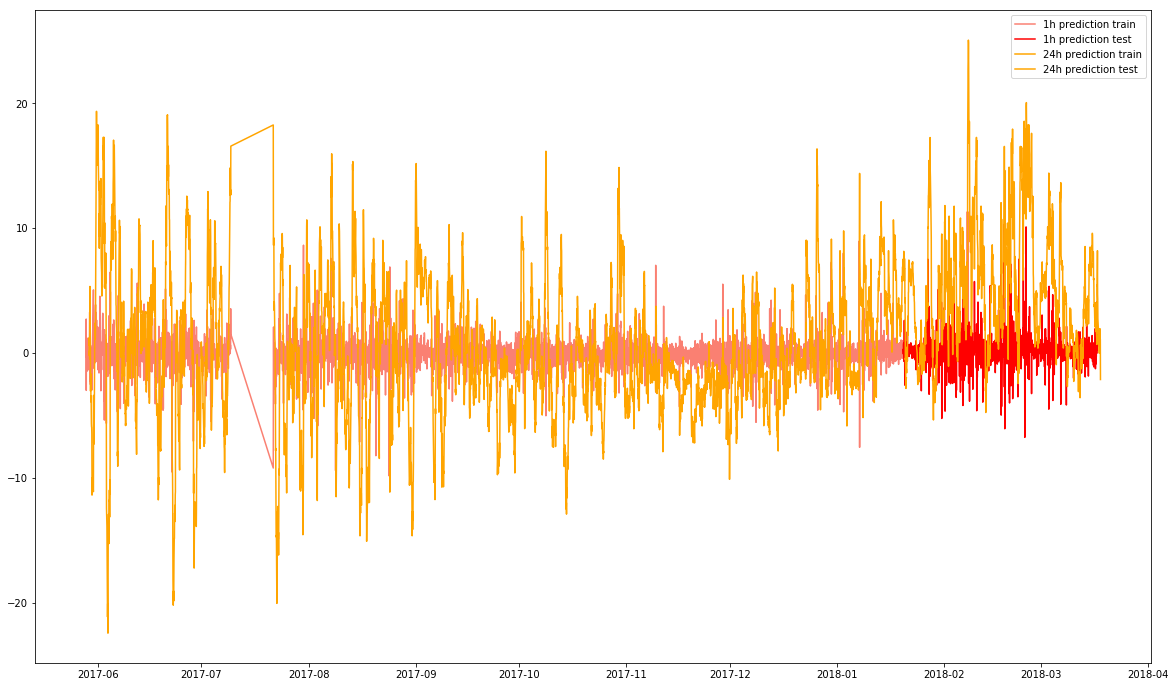

In [507]:
diff_train = np.subtract(predicted_train, y_train)
diff_test = np.subtract(predicted_test, y_test)

visualize_predictions(df, lookback, diff_train, diff_test, show_measured = False, label = "1h prediction")
visualize_predictions(df, lookback, diff_train, diff_test, show_measured = False, max_ahead = True, label = "24h prediction", train_color="orange", test_color="orange")

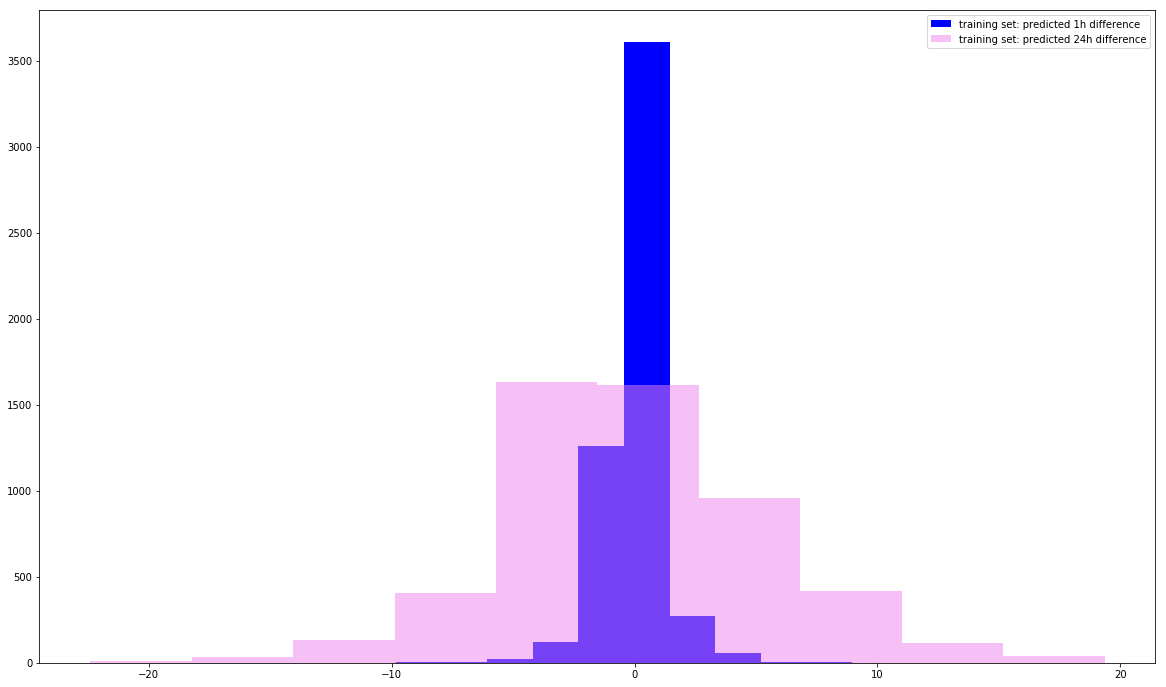

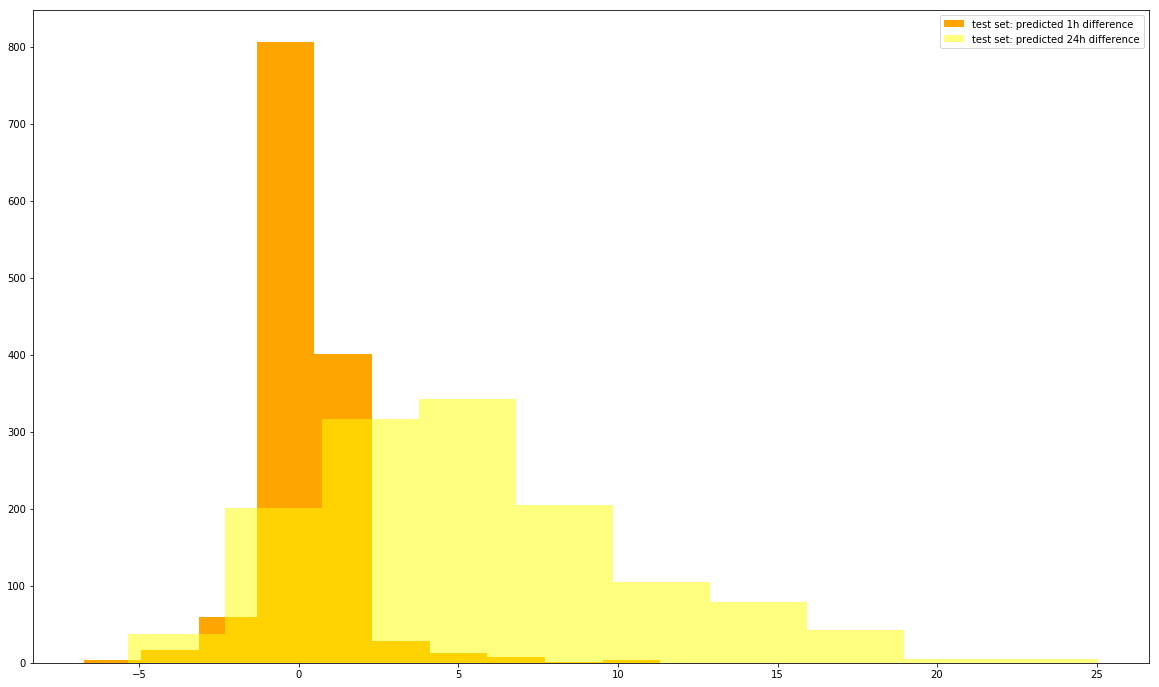

In [542]:
get_1h = lambda t: t[0]
get_24h = lambda t: t[-1]

train_1h = np.array([get_1h(x) for x in diff_train])
train_24h = np.array([get_24h(x) for x in diff_train])
test_1h = np.array([get_1h(x) for x in diff_test])
test_24h = np.array([get_24h(x) for x in diff_test])

plt.hist(train_1h, color = "blue", label = "training set: predicted 1h difference")
plt.hist(train_24h, color = "violet", alpha = 0.5, label = "training set: predicted 24h difference")
plt.legend()

plt.figure()
plt.hist(test_1h, color = "orange", label = "test set: predicted 1h difference")
plt.hist(test_24h, color = "yellow", alpha = 0.5, label = "test set: predicted 24h difference")
plt.legend()

plt.show()

In [508]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_rmse = math.sqrt(mean_squared_error(y_train, predicted_train))
test_rmse = math.sqrt(mean_squared_error(y_test, predicted_test))

print("RMSE on training set %.6f" % train_rmse)
print("RMSE on test set %.6f" % test_rmse)


print("MAE on training set %.6f" % mean_absolute_error(y_train, predicted_train))
print("MAE on test set %.6f" % mean_absolute_error(y_test, predicted_test))

RMSE on training set 4.294227
RMSE on test set 5.456307
MAE on training set 3.042295
MAE on test set 3.845732
